In [1]:
import torch
torch.manual_seed(0)
import torch.nn as nn
import matplotlib.pyplot as plt
from monotonic import MonotonicLinear, SwitchConvexity
from test_utils import run_test

DIM = 512

# Breaking Convexity

given an activation function $act(\cdot)$, a constrained MLP is a trasformation given by:
$$ f = L_n \circ act \circ L_{n-1} \circ \dots act \circ L_0 $$
Where $L_i$ are monotonic non decreasing affine trasformations parametrized by $W_i, b_i$ (with $W_i>=0$)

A sufficient condition for monotonicity of $f(x)$, is that the activation function $act(\cdot)$ is also monotonic.
Moreover, if $act(\cdot)$ is also convex, then $f(x)$ will also be convex.

This property allows us to parametrize monotonic convex network, however in most scenarios, being able to approximate only convex functions is not a desiderable proprerty.

A key observation is that by flipping the activation on both axes, we have easy access to another monotonic nonlinear function we can use as activation. In fact, if $act(z)$ is convex, then $-act(-z)$ is concave, but has the same monotonicity. 

By mixing this two activation functions in the network, we are no longer limited to learning convex functions. In fact, we will show that this is enough to recover the universal approximation property for a wide family of monotonic convex activation functions.

One interesting quirk of the sigmoid function is that $\sigma(x) = -\sigma(-x) +c$, therefore flipping it has no real effect.

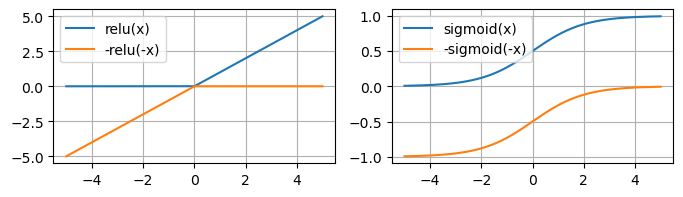

In [2]:
x = torch.linspace(-5, 5, 1000)
plt.figure(figsize=(8, 2))
plt.subplot(121)
plt.plot(x, torch.relu(x), label='relu(x)')
plt.plot(x, -torch.relu(-x), label='-relu(-x)')
plt.grid()
plt.legend()
plt.subplot(122)
plt.plot(x, torch.sigmoid(x), label='sigmoid(x)')
plt.plot(x, -torch.sigmoid(-x), label='-sigmoid(-x)')
plt.grid()
plt.legend()
plt.show()

# Universal approximation

## Theoretical derivation

A sufficient condition for a n layer MLP being a universal approximator is that it needs to be able to approximate the heavyside function arbitrary well with a finite number of hidden units.

This is true also for constrained MLP, where the weights are strictly positive.


When the activation function is the sigmoid, the universal approximator property holds trivially, even with a single hidden layer. Therefore a constrained MLP with 1 hidden layer and sigmoid activation is a universal approximator.

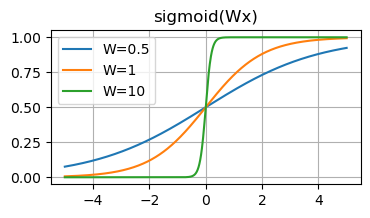

In [3]:
x = torch.linspace(-5, 5, 1000)
plt.figure(figsize=(4, 2))
plt.title('sigmoid(Wx)')
act = torch.sigmoid
for W in [0.5, 1, 10]:
    h1 = act(W*x)
    plt.plot(x, h1, label=f'W={W}')
plt.grid()
plt.legend()
plt.show()

The same is not true for non saturating activations (ReLU like functions).
While relu activated NN can approximate the heavyside function with a single layer, this involves negative weights. In fact, it is easy to show that a constrained MLP with 1 hidden layer is either constant, or diverges at infinity when the activation function is non saturating.
Therefore, a constrained MLP with non-saturating activations IS NOT an universal approximator.

However, when composing two layers it is indeed possible to approximate an heavyside function arbitrary well, provided we use both $act(x)$ and $-act(-x)$
This ensures that an MLP with 2 hidden layers IS an universal function approximator, when using RELU and similar non saturating functions.

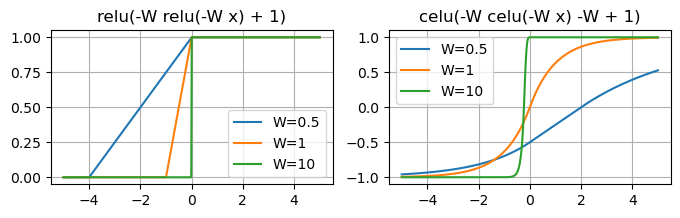

In [4]:
x = torch.linspace(-5, 5, 1000)

plt.figure(figsize=(8, 2))
plt.subplot(121)
plt.title('relu(-W relu(-W x) + 1)')
act = torch.relu
for W in [0.5, 1, 10]:
    h1 = -act(-W*x)
    h2 = act(W*h1+1)
    plt.plot(x, h2, label=f'W={W}')
plt.grid()
plt.legend()

plt.subplot(122)
plt.title('celu(-W celu(-W x) -W + 1)')
# The same works for CELU, but the params are less intuitive
act = torch.celu
for W in [0.5, 1, 10]:
    h1 = act(W*x)
    h2 = -act(-W*h1-W+1)
    plt.plot(x, h2, label=f'W={W}')
plt.grid()
plt.legend()

plt.show()

## Empirical evaluation

Indeed we can see that while 1 layer is enought to learn the target function when using a sigmoid activation, the relu activated network is unable to learn. 
However 2 hidden layers provide an universal approximator, and indeed are able to learn the complex target. In contrast to the sigmoid activated networks, since the ReLU family of activations does not have vanishing gradients, the optimization is more stable and it is easier to train larger networks.

relu 2 layer: 100%|██████████| 10000/10000 [01:12<00:00, 137.01it/s, rmse=0.0182]


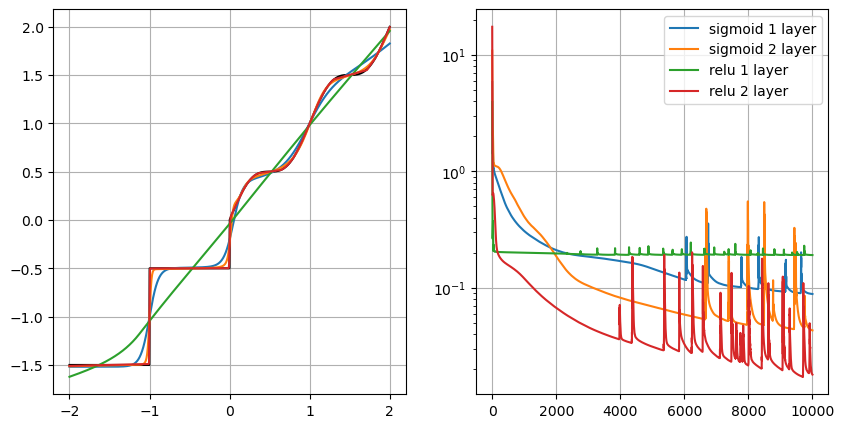

In [5]:
models = {
    f"sigmoid 1 layer": nn.Sequential(
        MonotonicLinear(1, DIM, weight_parametrization='abs'),
        nn.Sigmoid(),
        MonotonicLinear(DIM, 1, weight_parametrization='abs'),
    ),
    f"sigmoid 2 layer": nn.Sequential(
        MonotonicLinear(1, DIM, weight_parametrization='abs'),
        nn.Sigmoid(),
        MonotonicLinear(DIM, DIM, weight_parametrization='abs'),
        nn.Sigmoid(),
        MonotonicLinear(DIM, 1, weight_parametrization='abs'),
    ),
    f"relu 1 layer": nn.Sequential(
        MonotonicLinear(1, DIM, weight_parametrization='abs'),
        SwitchConvexity(nn.CELU(), DIM, learnable=False),
        MonotonicLinear(DIM, 1, weight_parametrization='abs'),
    ),
    f"relu 2 layer": nn.Sequential(
        MonotonicLinear(1, DIM, weight_parametrization='abs'),
        SwitchConvexity(nn.ReLU(), DIM, learnable=False),
        MonotonicLinear(DIM, DIM, weight_parametrization='abs'),
        SwitchConvexity(nn.ReLU(), DIM, learnable=False),
        MonotonicLinear(DIM, 1, weight_parametrization='abs'),
    )
}
run_test(models, "hard1d", lr=0.003, max_steps=10000);

# Alternative parametrizations

To recover the universal approximation property for Relu like functions, we need to use both $act(x)$ and $-act(-x)$. However, fixing in advance what hidden units use either activation might be suboptimal.

One solution is to use a learnable superposition of the two activations.
$$act_{\lambda}(x) = \lambda \, act(x) + (1-\lambda) \, act(-x)$$
Note that when the original activation is convex, the resulting activation function interpolates between a convex and concave function, depending on the learnable parameter lambda.
This approach of course has the drawback of needing additional parameters.

Another possible parametrization, makes use of an interesting observation on the structure of $act(x)$ and $-act(-x)$. In the context of a NN, this transformation is equivalent to "flipping" the weights of the neurons before and after the activation. Indeed, having positive weights is not a necesary condition for monotonicity, and this "double flipping" is one such condition where negative weights still result in monotone outputs.

Therefore if we separate the weights $W_i$ into positive and negative parts ($W_i = W_i^+ - W_i^-$) we can parametrize the linear trasformation as:
$$ W_i^+ act(x) - W_i^- act(-x) $$
This is a monotone transformation, without the need to reparametrize the weight matrix $W_i$.
One clear advantage of this parametrization is that each hidden unit can dinamically switch between convex and concave activation depending on the sign of its weight, offering the same upsides of a learnable superposition, without the need for extra parameters, and with more stable gradients

weight split: 100%|██████████| 10000/10000 [02:01<00:00, 82.56it/s, rmse=1.79]


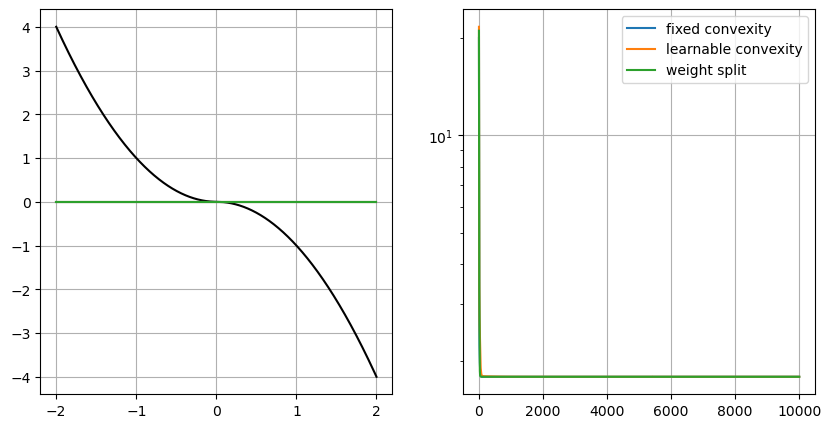

weight split: 100%|██████████| 10000/10000 [02:01<00:00, 81.99it/s, rmse=0.0151]


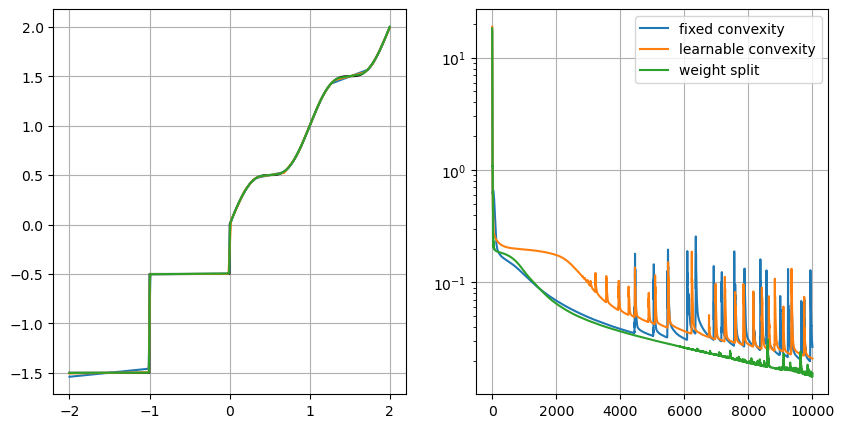

In [6]:
models = {
    f"fixed convexity": nn.Sequential(
        MonotonicLinear(1, DIM, weight_parametrization='abs'),
        SwitchConvexity(nn.ReLU(), DIM, learnable=False),
        MonotonicLinear(DIM, DIM, weight_parametrization='abs'),
        SwitchConvexity(nn.ReLU(), DIM, learnable=False),
        MonotonicLinear(DIM, 1, weight_parametrization='abs'),
    ),
    f"learnable convexity": nn.Sequential(
        MonotonicLinear(1, DIM, weight_parametrization='abs'),
        SwitchConvexity(nn.ReLU(), DIM, learnable=True),
        MonotonicLinear(DIM, DIM, weight_parametrization='abs'),
        SwitchConvexity(nn.ReLU(), DIM, learnable=True),
        MonotonicLinear(DIM, 1, weight_parametrization='abs'),
    ),
    f"weight split": nn.Sequential(
        MonotonicLinear(1, DIM, pre_activation=nn.Identity()),
        MonotonicLinear(DIM, DIM, pre_activation=nn.ReLU()),
        MonotonicLinear(DIM, 1, pre_activation=nn.ReLU()),
    ),
}
run_test(models, "hard1d", lr=0.003, max_steps=10000);

By trying to learn a simple decreasing function we can sanity check that we are parametrizing only monotonicly non decresing functions. Indeed all of the model find the best nonndecresing approximation, that is a constant line.

In [ ]:
run_test(models, "decreasing", lr=0.003, max_steps=10000);

# Multi input

the

In [2]:
models = {
    f"sigmoid 1 layer": nn.Sequential(
        MonotonicLinear(2, DIM, weight_parametrization='abs'),
        nn.Sigmoid(),
        MonotonicLinear(DIM, 1, weight_parametrization='abs'),
    ),
    f"sigmoid 2 layer": nn.Sequential(
        MonotonicLinear(2, DIM, weight_parametrization='abs'),
        nn.Sigmoid(),
        MonotonicLinear(DIM, DIM, weight_parametrization='abs'),
        nn.Sigmoid(),
        MonotonicLinear(DIM, 1, weight_parametrization='abs'),
    ),
    "relu 2 layers":nn.Sequential(
        MonotonicLinear(2, DIM, pre_activation=nn.Identity()),
        MonotonicLinear(DIM, DIM, pre_activation=nn.ReLU()),
        MonotonicLinear(DIM, 1, pre_activation=nn.ReLU()),
    ),
    "relu 3 layers":nn.Sequential(
        MonotonicLinear(2, DIM, pre_activation=nn.Identity()),
        MonotonicLinear(DIM, DIM, pre_activation=nn.ReLU()),
        MonotonicLinear(DIM, DIM, pre_activation=nn.ReLU()),
        MonotonicLinear(DIM, 1, pre_activation=nn.ReLU()),
    )
}

relu 3 layers: 100%|██████████| 10000/10000 [02:52<00:00, 57.91it/s, rmse=0.0335]


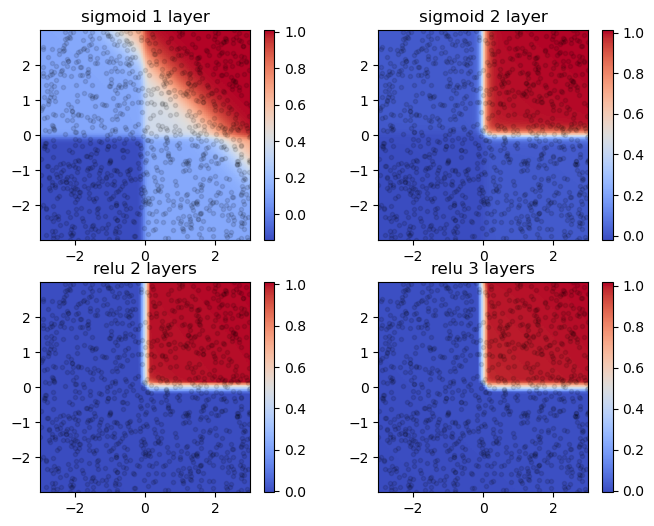

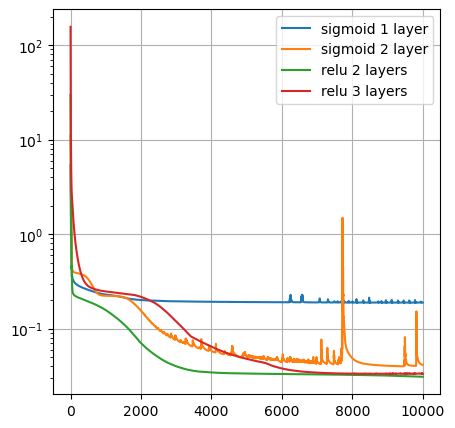

In [3]:
run_test(models, "easy2d", lr=0.003, max_steps=10000);